# Machine learning compilation of quantum circuits
> Optimal compiling of unitaries reaching the theoretical lower bound

- toc: true 
- badges: true
- comments: true
- categories: [machine learning, compilation, qiskit]
- image: 

# Introduction

I am going to review a recent [preprint](http://arxiv.org/abs/2106.05649) by Liam Madden and
Andrea Simonetto that uses techniques from machine learning to tackle the problem of quantum circuits compilation. I find the approach suggested in the paper very interesting and the preliminary results quite promising.

## What is compilation?
But first things first, what is a compilation of a quantum circuit? The best motivation and illustration for the problem is the following. Say you need to run a textbook quantum circuit on a real hardware. The real hardware usually allows only for a few basic one and two qubit gates. In contrast, your typical textbook quantum circuit may feature (1) complex many-qubit gates, for example multi-controlled gates and (2) one and two qubit gates which are not supported by the hardware. As a simple example take this 3-qubit Grover's circuit (from [qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html)):

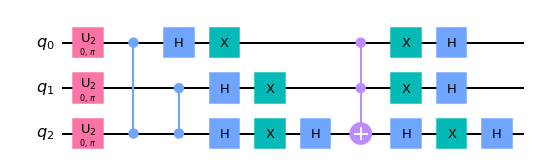

In [1]:
# collapse
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit = grover_circuit.decompose()
grover_circuit.draw(output='mpl')

The three qubit gates like Toffoli are not generally available on a hardware and one and two qubit gates my be different from those in the textbook algorithm. For example ion quantum computers are good with [Mølmer–Sørensen gates](https://en.wikipedia.org/wiki/M%C3%B8lmer%E2%80%93S%C3%B8rensen_gate) and may need several native one qubit gates to implement the Hadamard gate.

Additional important problem is to take into account qubit connectivity. Usually textbook algorithms assume full connectivity, meaning that two-qubit gates can act on any pair of qubits. On most hardware platforms however a qubit can only interact with its neighbors. Assuming that one and two qubits gates available on the hardware can implement a SWAP gate between adjacent qubits, to solve the connectivity problem one can insert as many SWAPs as necessary to connect topologically disjoint qubits. Using SWAPs however leads to a huge overhead in the number of total gates in the compiled circuit, and it is of much importance use them as economically as possible. In fact, the problem of optimal SWAPping alone in generic situation is [NP-complete](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=on+the+complexity+of+quantum+circuit+compilation&btnG=).

## Simplified problem
When compiling a quantum circuit one has to decide which resulting circuits are considered to be efficient. Ideally, one should optimize for the total fidelity of the circuit. However, if one thinks about a fidelity of the compiled circuit when implemented on a real hardware many more details need to be taken into account. For example, gates acting on different qubits or pairs of qubits may have different fidelities. Decoherence of qubits with time can make circuits where many operations can be executed in parallel more favorable. Cross-talk (unwanted interactions) between neighboring qubits may lead to exotic patterns for optimal circuits. A simple proxy for the resulting fidelity that is often adopted is the number of two-qubit gates (which are generically much less accurate than a single-qubit gates). So the problem that is often studied, and that is addressed in the preprint we are going to discuss, is the problem of optimal compilation into a gate set consisting of arbitrary single-qubit gates and CNOTs, the only two qubits gates. The compiled circuit must 

1. Respect hardware connectivity
1. Have as few CNOTs as possible
1. Exceed a given fidelity threshold.

Last item here means that we also allow for approximate compilation. By increasing the number of CNOTs one can always achieve an exact compilation, but since in reality each additional CNOT comes with its own fidelity cost this might not be a good trade-off. Note also a specific choice for two-qubit gate is made, a CNOT gate. Any two-qubit gate can be decomposed into at most 3 CNOTs [see e.g. here](https://arxiv.org/pdf/quant-ph/0308006.pdf), so in terms of computational complexity this is of course inconsequential. However in the following discussion we will care a lot about constant factors and may wish to revisit this choice in the end.

# Points to address
1. What is CNOT CNOT?
1. Does qiskit 4Toffoli have pretty angles?
1. Understand how cart works?
1. Limitations of compiling unitaries -- large number of qubits
1. Why choose CNOTs?